# Albedo decomposition



In [4]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
fh.disable_warnings()
import postprocessing as pp
import xarray as xr

def add_albedo(dataset):
    dataset['albedo'] = dataset['sou_t'] / dataset['sod_t']
    return dataset

def get_data(exp_dir='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/'):
    datasets = [pp.clean_surface_data(fh.disk_data_from_keywords(exp_dir, ['surface'  , 'DOM01'])), 
                pp.clean_surface_data(fh.disk_data_from_keywords(exp_dir, ['radiation', 'DOM01']))]
    datasets = [ds.drop_duplicates(dim='time') for ds in datasets]
    data = xr.merge(datasets)
    
    data = add_control(data)
    data = pp.add_grid(data)
    data = pp.cut_borders(data)
    data = add_albedo(data)
    return data
    
def add_control(input_data, domain='DOM01'):
    datasets = list()
    for kind in ['surface', 'radiation']:
        data = fh.eureca_data_from_keywords([kind, domain])
        datasets.append(data)
    datasets = pp.subset_time_overlap(datasets)
    data = xr.merge(datasets)
    data = data.expand_dims(exp=('control',))
    input_data = input_data.expand_dims(exp=('warming',))
    
    datasets = [input_data, data]
    datasets = pp.filter_common_vars(datasets)
    datasets = pp.subset_time_overlap(datasets)
    return xr.concat(datasets, dim='exp')
    
data = get_data()
data

Any code that generates warnings will no longer print them to the console.


<xarray.Dataset> Size: 394GB
Dimensions:        (cell: 2154774, exp: 2, time: 1143)
Coordinates:
    lat            (cell) float64 17MB 9.501 9.5 9.507 ... 13.02 13.01 13.01
    lon            (cell) float64 17MB -47.75 -47.76 -47.77 ... -51.36 -51.37
  * cell           (cell) int64 17MB 396191 396193 396214 ... 4469910 4469911
  * exp            (exp) object 16B 'warming' 'control'
  * time           (time) datetime64[ns] 9kB 2020-01-09T10:00:00 ... 2020-01-...
Data variables: (12/20)
    rh_2m          (exp, time, cell) float32 20GB dask.array<chunksize=(1, 1, 251586), meta=np.ndarray>
    u_10m          (exp, time, cell) float32 20GB dask.array<chunksize=(1, 1, 251586), meta=np.ndarray>
    sod_t          (exp, time, cell) float32 20GB dask.array<chunksize=(1, 1, 905712), meta=np.ndarray>
    tqi_dia        (exp, time, cell) float32 20GB dask.array<chunksize=(1, 1, 251586), meta=np.ndarray>
    qv_2m          (exp, time, cell) float32 20GB dask.array<chunksize=(1, 1, 251586), meta=np.ndarray>
    v_10m          (exp, time, cell) float32 20GB dask.array<chunksize=(1, 1, 251586), meta=np.ndarray>
    ...             ...
    pres_sfc       (exp, time, cell) float32 20GB dask.array<chunksize=(1, 1, 251586), meta=np.ndarray>
    sob_t          (exp, time, cell) float32 20GB dask.array<chunksize=(1, 1, 905712), meta=np.ndarray>
    tqv_dia        (exp, time, cell) float32 20GB dask.array<chunksize=(1, 1, 251586), meta=np.ndarray>
    clct           (exp, time, cell) float32 20GB dask.array<chunksize=(1, 1, 251586), meta=np.ndarray>
    rain_gsp_rate  (exp, time, cell) float32 20GB dask.array<chunksize=(1, 1, 251586), meta=np.ndarray>
    albedo         (exp, time, cell) float32 20GB dask.array<chunksize=(1, 1, 905712), meta=np.ndarray>
Attributes: (12/18)
    ICON_grid_file_uri:   
    centre:               78
    crs_id:               urn:ogc:def:cs:EPSG:6.0:6422
    crs_name:             Spherical 2D Coordinate System
    ellipsoid_name:       Sphere
    global_grid:          0
    ...                   ...
    semi_major_axis:      6371229.0
    source:               svn://xceh.dwd.de/for0adm/SVN_icontools/tags/iconto...
    subcentre:            255
    title:                ICON grid description
    uuidOfHGrid:          6b59890b-99f3-939b-e76a-0a3ad2e43140
    uuidOfParHGrid:       39f9d5e2-322c-11e6-beee-d15f30d0a215

In [9]:
print(pp.filter_by_threshold(data.sel(exp='control'), {'clct':0.5}).mean(dim=['cell', 'time'], keep_attrs=True)['albedo'].values)
print(pp.filter_by_threshold(data.sel(exp='warming'), {'clct':0.5}).mean(dim=['cell', 'time'], keep_attrs=True)['albedo'].values)
print(pp.filter_by_threshold(data.sel(exp='control'), {'clct':0.5}, below_threshold=True).mean(dim=['cell', 'time'], keep_attrs=True)['albedo'].values)
print(pp.filter_by_threshold(data.sel(exp='warming'), {'clct':0.5}, below_threshold=True).mean(dim=['cell', 'time'], keep_attrs=True)['albedo'].values)

0.27769765
0.34835333
0.17904279
0.16049387


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

albedo_values = [
    pp.filter_by_threshold(data.sel(exp='control'), {'clct':0.5}),
    pp.filter_by_threshold(data.sel(exp='warming'), {'clct':0.5}),
    pp.filter_by_threshold(data.sel(exp='control'), {'clct':0.5}, below_threshold=True),
    pp.filter_by_threshold(data.sel(exp='warming'), {'clct':0.5}, below_threshold=True),
]
data_arrays = [np.ravel(d['albedo'].values) for d in albedo_values]
labels = ['control cloud', 'warming cloud', 'control clear', 'warming clear']

fig, ax = plt.subplots()
ax.boxplot(data_arrays, labels=labels)
ax.set_ylabel('Albedo')
fig.show()

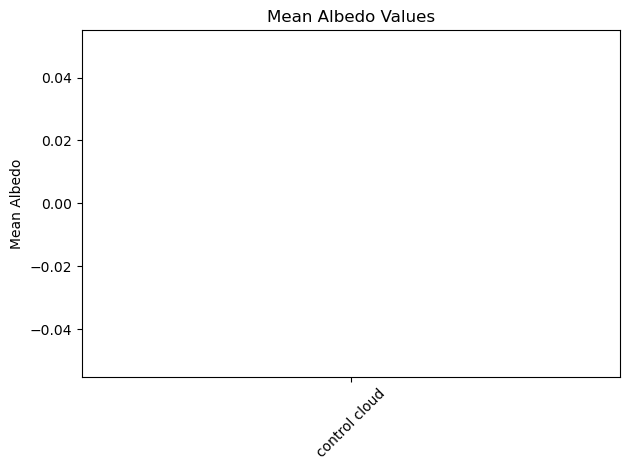

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the mean of each albedo value array
albedo_values = [
    pp.filter_by_threshold(data.sel(exp='control'), {'clct':0.5}),
    pp.filter_by_threshold(data.sel(exp='warming'), {'clct':0.5}),
    pp.filter_by_threshold(data.sel(exp='control'), {'clct':0.5}, below_threshold=True),
    pp.filter_by_threshold(data.sel(exp='warming'), {'clct':0.5}, below_threshold=True),
]
means = [np.mean(np.ravel(d['albedo'].values)) for d in albedo_values]
labels = ['control cloud', 'warming cloud', 'control clear', 'warming clear']

# Plot the means
fig, ax = plt.subplots()
ax.bar(labels, means)
ax.set_ylabel('Mean Albedo')
ax.set_title('Mean Albedo Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()